# ISA $\alpha=3$

Ok, it's promising to use $\alpha=3$ in our combined loss $\mathcal{L}_{tot} = \mathcal{L}_{BCE} + \alpha \cdot \mathcal{L}_{MSE}$, because:

- it's lower than BCE (see Nicoles notebook) and we would like them to  "compete" to get the best possible result.
- the (x,y,R) is badly learned for rings at the edges as it only learns to get the center of gravity and does not take into account that rings might be only shown partiallly -> more weight on MSE to solve this?

### Load model, make data etc.

import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('./../../code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import InvariantSlotAttention

from matplotlib.patches import Circle
import json

# Set numpy seed for test set sampling 
np.random.seed(24082023)

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cpu'

In [3]:
cID_prev = 'isa-alpha3'
with open(f'./../../code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

In [4]:
torch_seed = 24082023
torch.manual_seed( torch_seed )

import random
random.seed(torch_seed)

In [5]:
m = InvariantSlotAttention(**hps)

**At what iteration load the model**? -> Have a look at the loss

In [6]:
f = open(f'./../../code/models/{cID_prev}/loss.json')
# returns JSON object as a dictionary
losses = json.load(f)

loss  tot  min:  0.024983521550893784  at  10700
loss  bce  min:  0.015853151679039  at  10596
loss  mse  min:  0.00222270586527884  at  10746


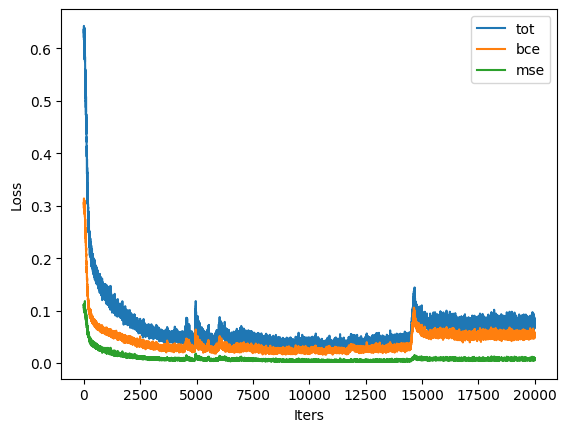

In [7]:
for k,v in losses.items():
    plt.plot(v,label=k)
    print("loss ", k, " min: ", np.min(v), " at ", np.argmin(v))
plt.xlabel('Iters')
plt.ylabel('Loss')
plt.legend()
plt.show()

choose 11000!

In [8]:
lastIter = 11000
weightPath = f'./../../code/models/{cID_prev}/m_{lastIter}.pt'
print(f'Starting from an earlier training',lastIter)

m.load_state_dict(torch.load(weightPath,map_location=device))

Starting from an earlier training 11000


<All keys matched successfully>

In [9]:
bs = 1000
kwargs = cd['data']

X, Y, mask = make_batch(N_events=bs, **kwargs)

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/Invariant-Slot-Attention (ISA) methods/./../../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


In [10]:
#for i in range(10):
#    plt.imshow(X[i][0])
#    plt.show()

### Evaluate the model

In [11]:
from train import hungarian_matching
import torch.nn.functional as F

k_slots=3
max_n_rings=2
resolution=(32,32)

In [12]:
alpha = cd['opt']['alpha']

In [13]:
with torch.no_grad():

    torch.manual_seed(torch_seed)
    queries, att, Y_pred = m(X)
         
    # Reshape the target mask to be flat in the pixels (same shape as att)
    flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      

    att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
    mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 

    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)

    # pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
    indices = hungarian_matching(pairwise_cost)

    # Apply the sorting to the predict
    bis=torch.arange(bs).to(device)
    indices=indices.to(device)

    # Loss calc
    slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)

    Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean(axis=-1)

    # Calculate the loss
    print(l_bce.shape)
    print(l_mse.shape)
    li = l_bce + alpha*l_mse
    

torch.Size([1000])
torch.Size([1000])


### Look at examples

In [14]:
def plot_chosen_slots_only(mask, att_img, Y_true, Y_pred, color='C0',cmap='Blues',figname=''):
    n_rings = att_img.shape[0]
    fig, axs = plt.subplots(1,n_rings+1,figsize=(3*(n_rings + 2) ,2.5))
   
    imgs   = [mask] + [att_img[i] for i in range(n_rings)]
    titles = ['Target']+[f'Slot {i}' for i in range(n_rings)]
    extent = [-0.5, 0.5]*2
    for i, (ax,img,title) in enumerate(zip(axs[0:],imgs, titles)):
        
        im = ax.imshow(img.detach().cpu().numpy(),cmap=cmap,
                       extent=extent,origin='lower') #,vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(title)
        

    # Add on the target image
    axi = axs[0]
    c_true = 'r'
    c_pred = 'k'
    for yi in Y_true.cpu().numpy():
    
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
    
    for axi,yi,oi in zip(axs[1:],Y_true.cpu().numpy(),Y_pred.detach().cpu().numpy()):
        
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.scatter(*oi[:2],marker='x',color=c_pred)
        circle = Circle(oi[:2],oi[2],fill=False,color=c_pred)
        axi.add_patch(circle)

        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
        
    #if figname:
    #    plt.savefig(figname)

    plt.show()
    plt.close()

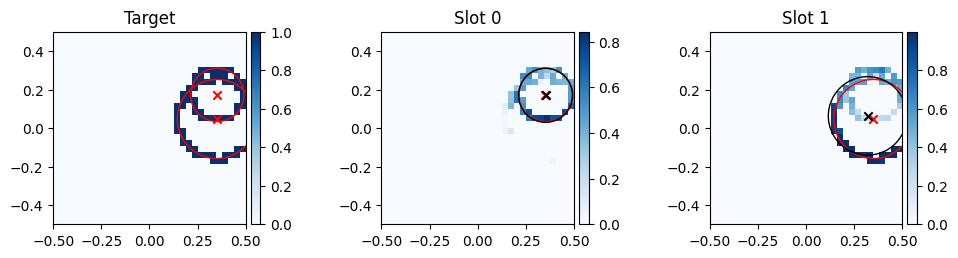

In [15]:
iEvt = 8

plot_chosen_slots_only(
                  mask[iEvt].sum(axis=0), 
                  slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                  Y_true_sorted[iEvt],
                  Y_pred_sorted[iEvt])

In [56]:
#rings_sorted[iEvt].shape
#plt.imshow(rings_sorted[iEvt][1].reshape((32, 32)), cmap='Blues', origin="lower")
#plt.colorbar()

ok this looks cool! Slot 1 looks good at it does learn more than center of gravity for x,y,R!

Check KL-divergence and good and bad examples!

In [16]:
l_kl = F.kl_div(torch.log(slots_sorted),rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)

In [44]:
10e-5

0.0001

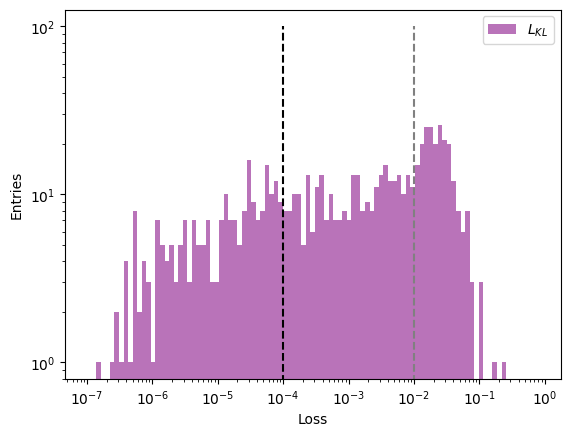

In [17]:
bins = np.array([10e-4,10e-3, 10e-2, 10e-1])
bins= 10**(np.linspace(-7, -0.1, 100))
plt.hist(l_kl, color='purple', label="$L_{KL}$", alpha=0.55, bins=bins)

#plt.hist(l_bce.numpy(),100,color='r', label="$L_{BCE}$", alpha=0.55, range=(0, 0.35))
plt.xlabel('Loss')
plt.ylabel('Entries')

ylim = plt.ylim()
plt.vlines([10e-5, 10e-3], 0, 100, colors=['black', 'grey'], linestyle="--")

#plt.plot([10e-4]*2,ylim,'k--')
#plt.plot([10e-2]*2,ylim,'grey',ls='--')

plt.legend()
plt.yscale("log")
plt.xscale("log")

plt.show()

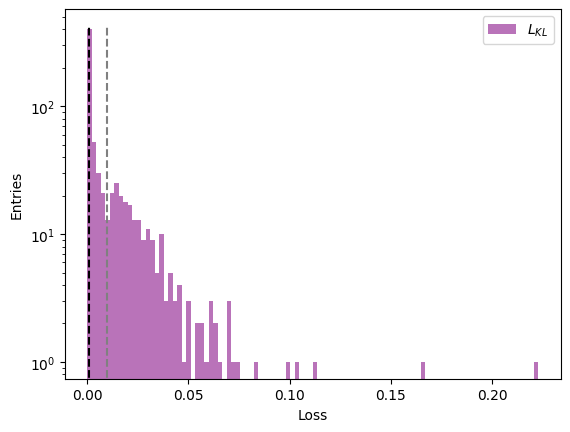

In [18]:
plt.hist(l_kl, color='purple', label="$L_{KL}$", alpha=0.55, bins=100)

#plt.hist(l_bce.numpy(),100,color='r', label="$L_{BCE}$", alpha=0.55, range=(0, 0.35))
plt.xlabel('Loss')
plt.ylabel('Entries')

ylim = plt.ylim()
plt.plot([.001]*2,ylim,'k--')
plt.plot([.01]*2,ylim,'grey',ls='--')

plt.legend()
plt.yscale("log")

plt.show()

Show log(KL)

In [ ]:
bins = np.arange(4)[::-1]
print(bins)

In [ ]:

### FINISH THIS CELL!!!

bins = np.arange(4)[::-1]
bins= 10**(np.linspace(-7, -0.1, 100))
plt.hist(l_kl, color='purple', label="$L_{KL}$", alpha=0.55, bins=bins)

#plt.hist(l_bce.numpy(),100,color='r', label="$L_{BCE}$", alpha=0.55, range=(0, 0.35))
plt.xlabel('Loss')
plt.ylabel('Entries')

ylim = plt.ylim()
plt.vlines([10e-5, 10e-3], 0, 100, colors=['black', 'grey'], linestyle="--")

#plt.plot([10e-4]*2,ylim,'k--')
#plt.plot([10e-2]*2,ylim,'grey',ls='--')

plt.legend()
plt.yscale("log")
plt.xscale("log")

plt.show()

In [19]:
mi = l_kl < 10e-5 # good events
torch.sum(mi)
mj = l_kl > 10e-3 # bad events
torch.sum(mj)

good_imgs = mask[mi].sum(axis=1)
bad_imgs  = mask[mj].sum(axis=1)

**Bad examples**

In [42]:
10e-3 # makes so much sense!!

0.01

KL:  tensor(0.0308)


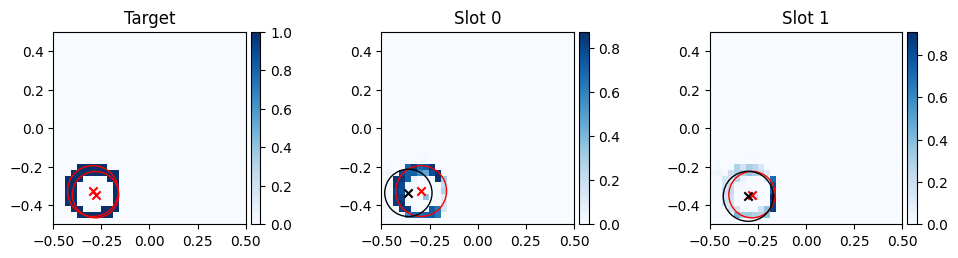

KL:  tensor(0.0408)


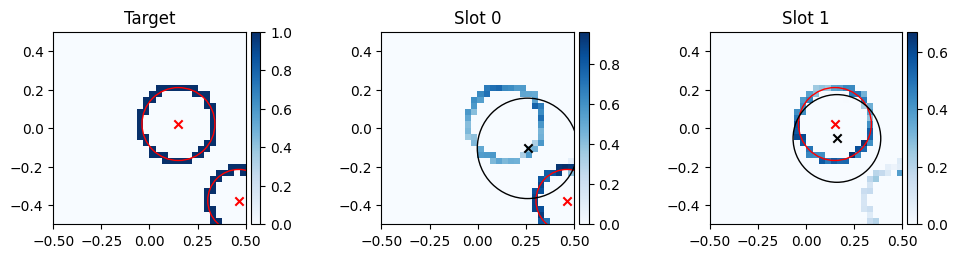

KL:  tensor(0.0643)


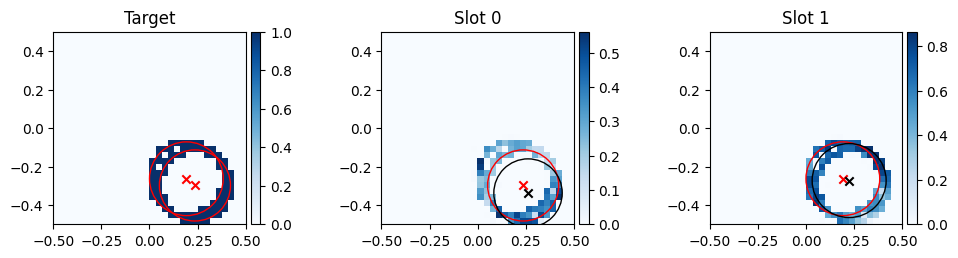

KL:  tensor(0.0200)


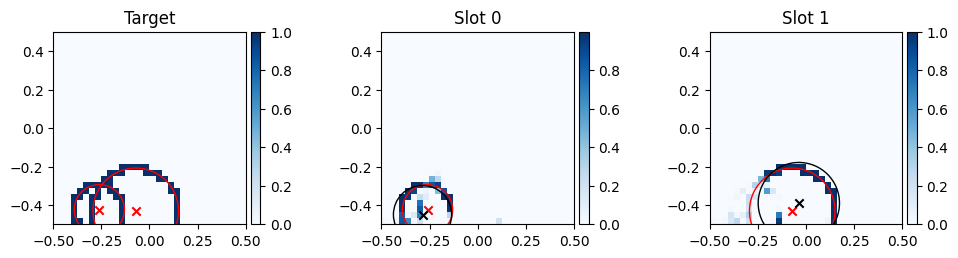

KL:  tensor(0.0185)


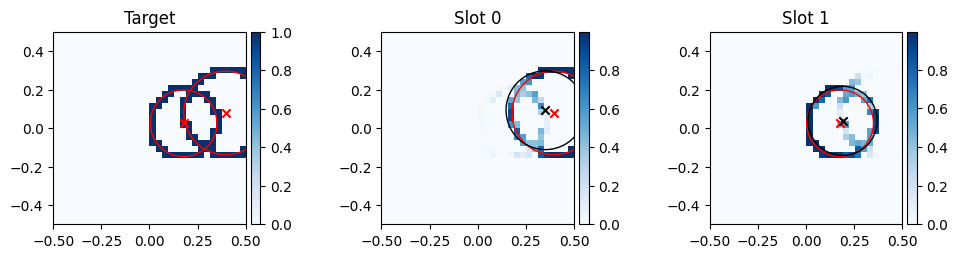

KL:  tensor(0.0621)


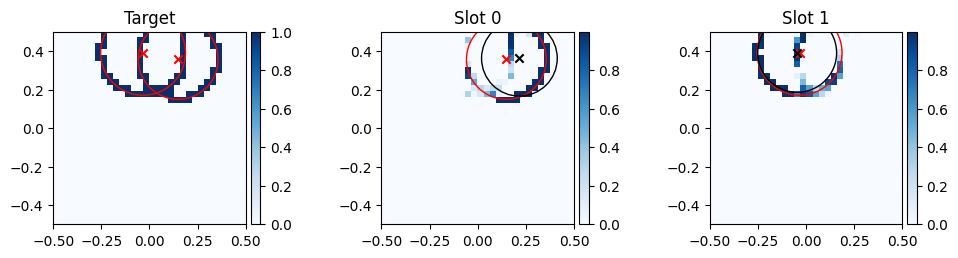

KL:  tensor(0.0175)


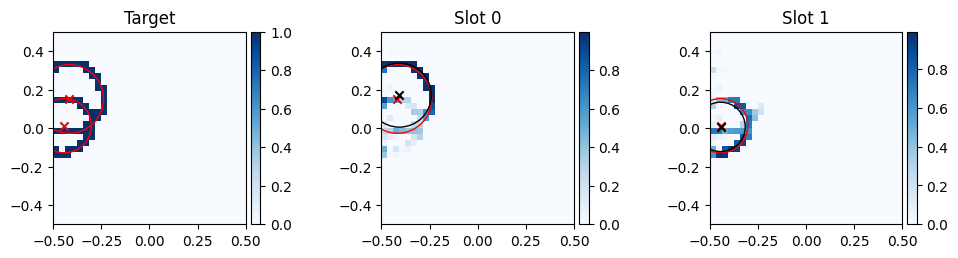

KL:  tensor(0.0130)


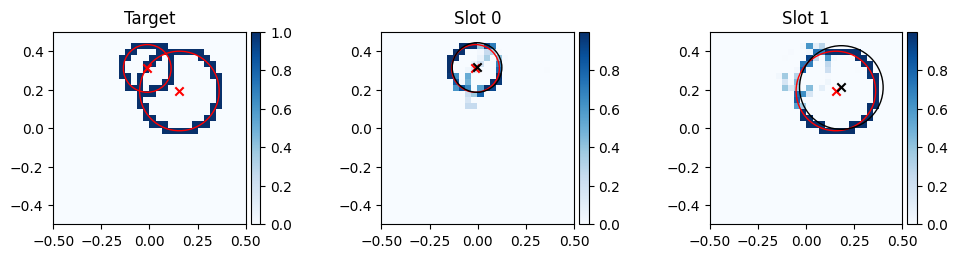

KL:  tensor(0.0233)


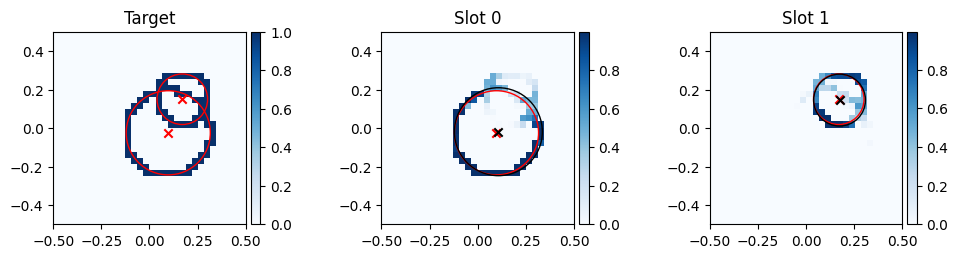

KL:  tensor(0.0376)


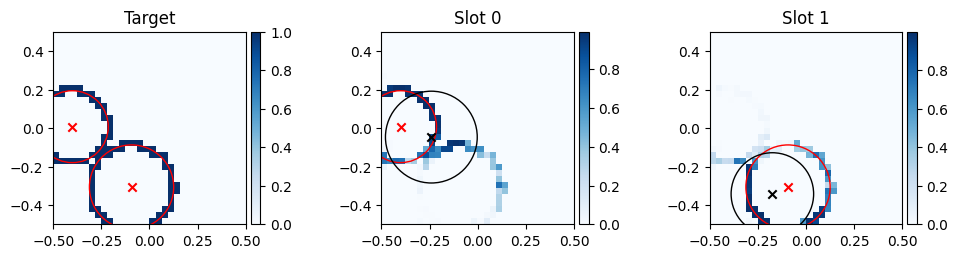

KL:  tensor(0.0151)


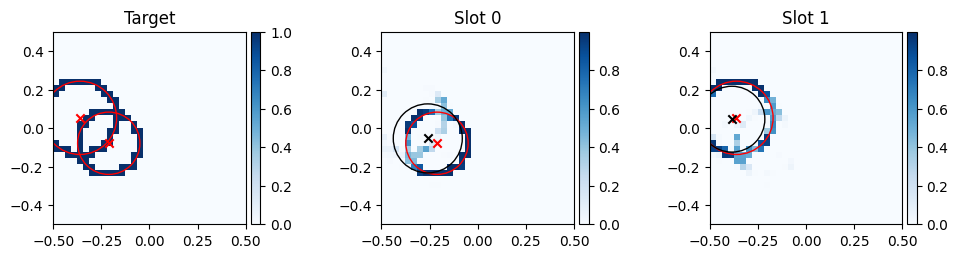

KL:  tensor(0.0100)


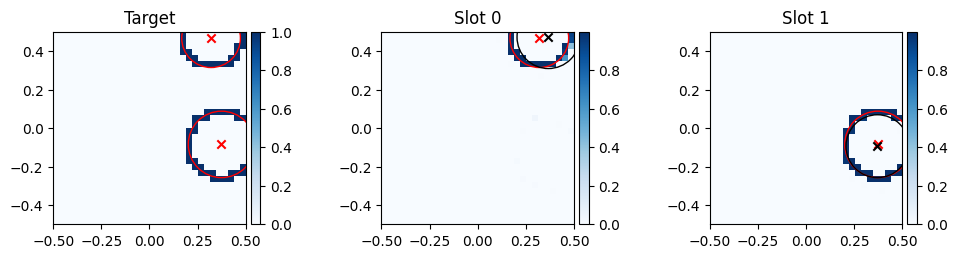

KL:  tensor(0.0144)


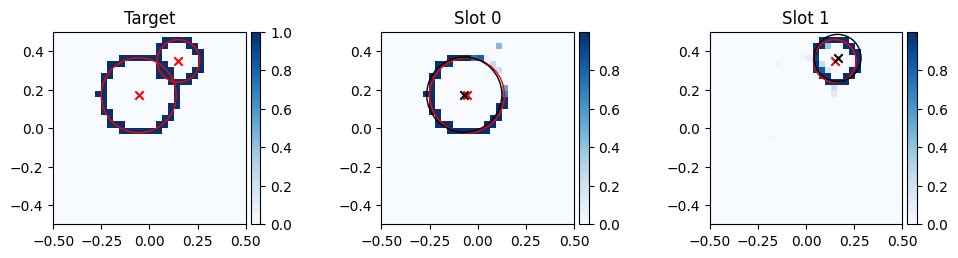

KL:  tensor(0.0240)


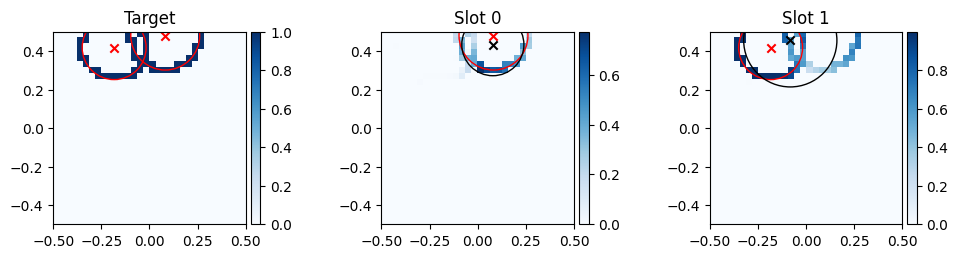

KL:  tensor(0.0324)


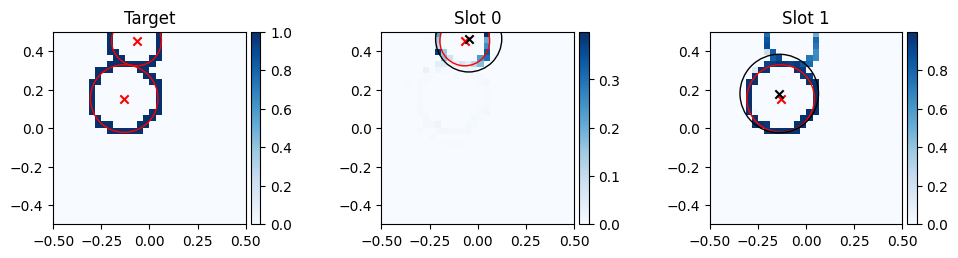

KL:  tensor(0.2227)


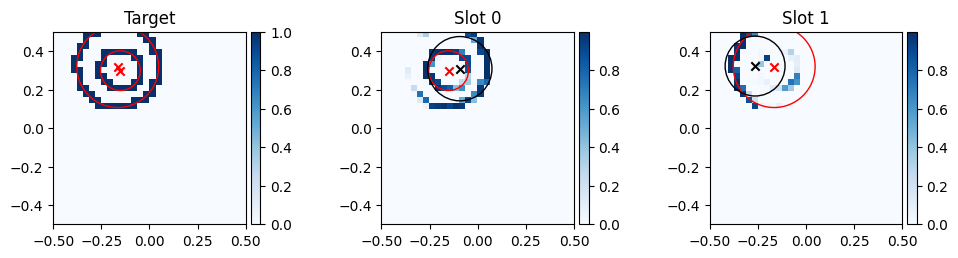

KL:  tensor(0.0298)


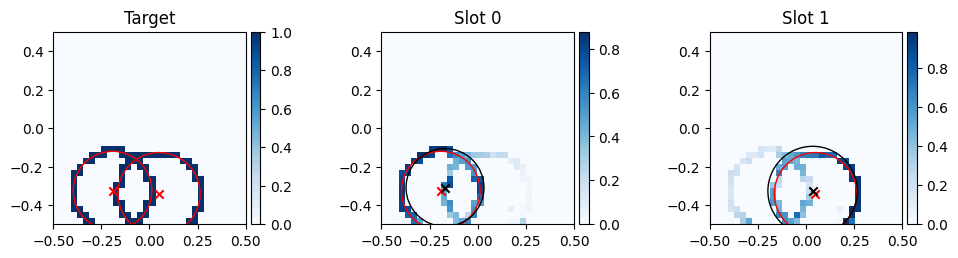

In [20]:
for count, k in enumerate(np.where(l_kl > 10e-3)[0]):
    iEvt = k
    print("KL: ", l_kl[iEvt])
    plot_chosen_slots_only(
                  mask[iEvt].sum(axis=0), 
                  slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                  Y_true_sorted[iEvt],
                  Y_pred_sorted[iEvt])
    if count>15:
        break

**Good expamles**

KL:  tensor(1.5598e-05)


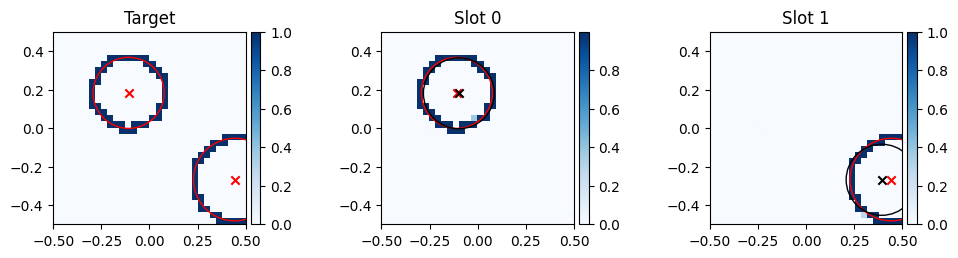

KL:  tensor(2.6144e-06)


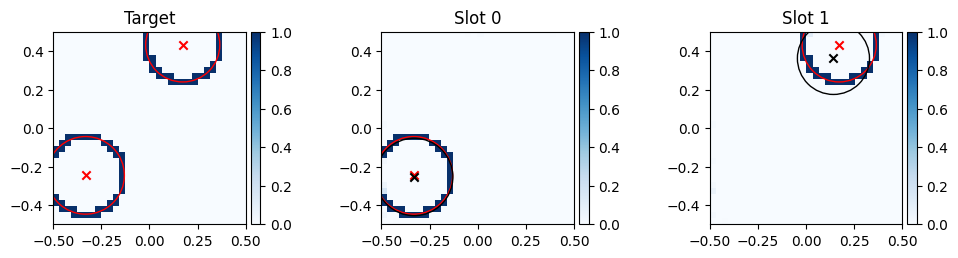

KL:  tensor(1.1986e-06)


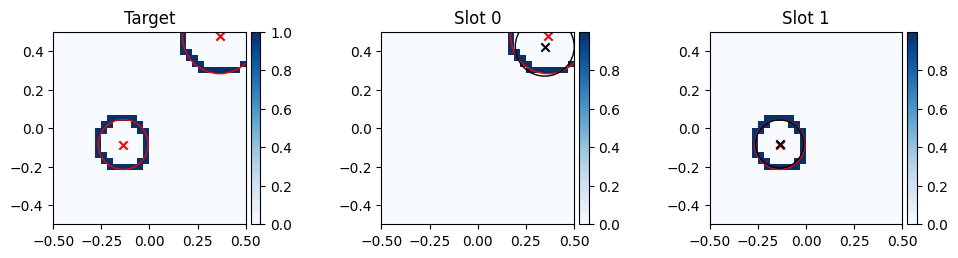

KL:  tensor(5.8157e-05)


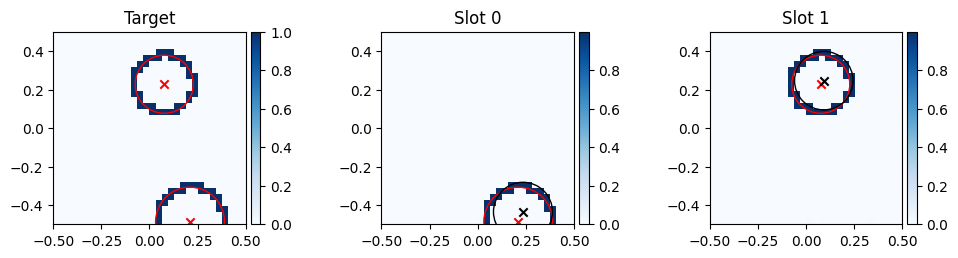

KL:  tensor(1.8521e-06)


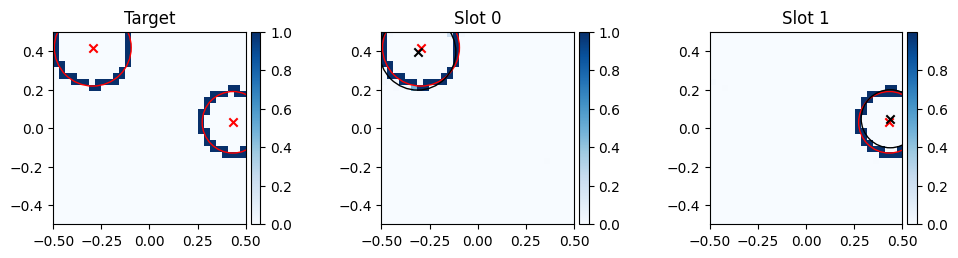

KL:  tensor(1.2407e-06)


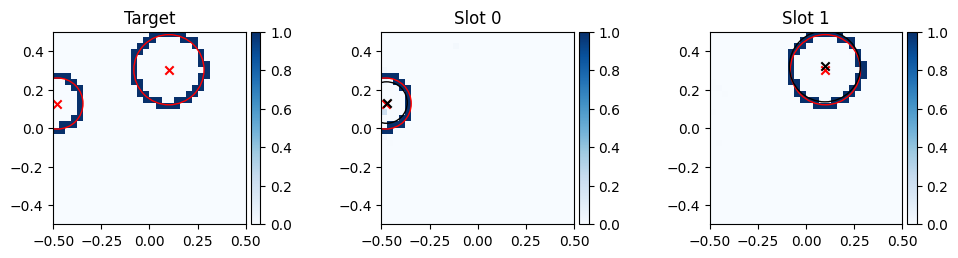

KL:  tensor(2.5141e-05)


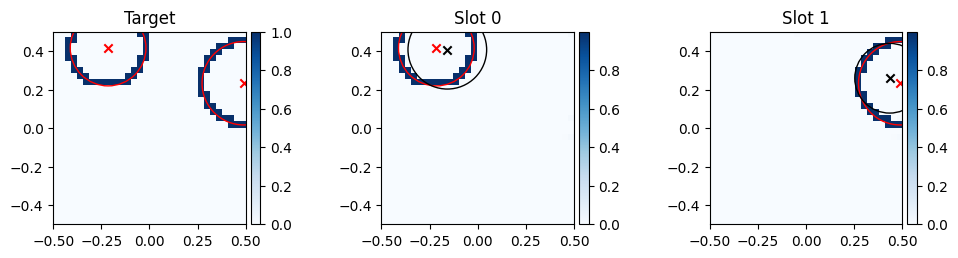

KL:  tensor(9.8857e-05)


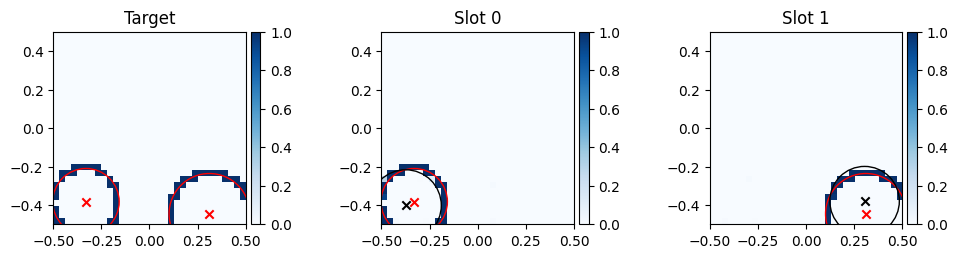

KL:  tensor(8.7437e-05)


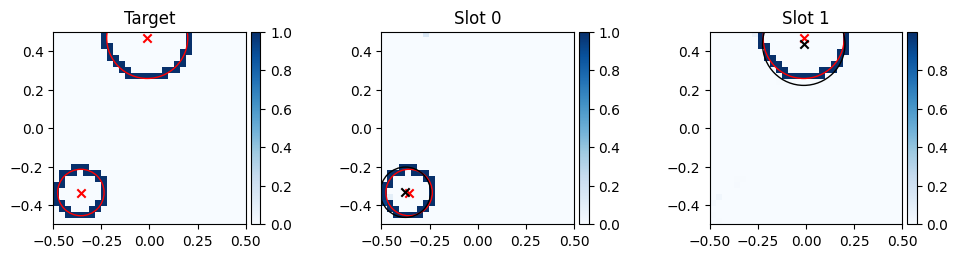

KL:  tensor(5.1780e-06)


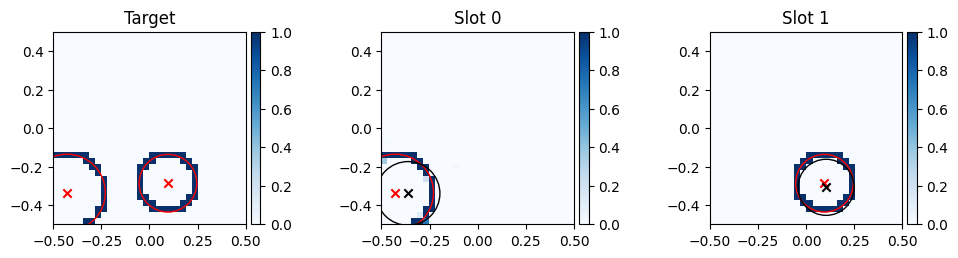

KL:  tensor(8.6742e-07)


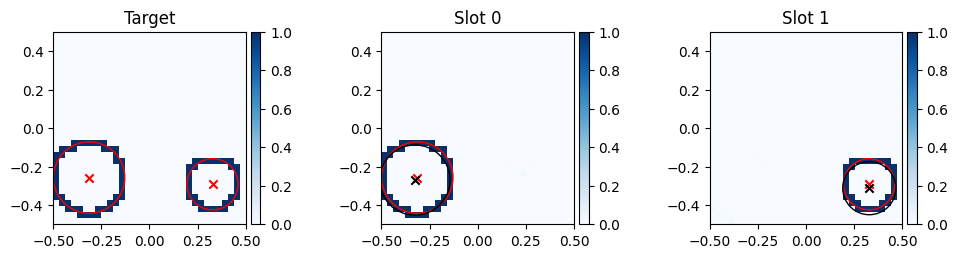

KL:  tensor(5.7217e-05)


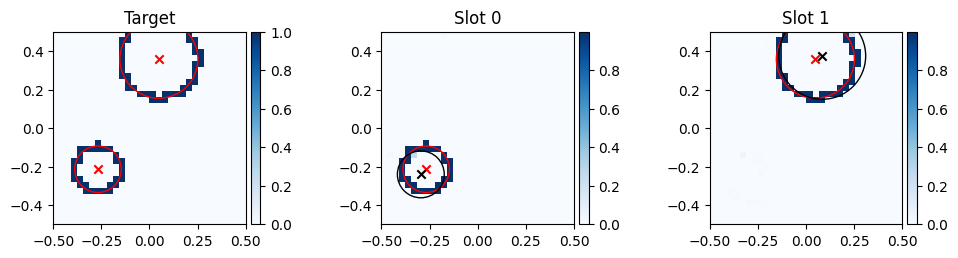

KL:  tensor(1.3649e-06)


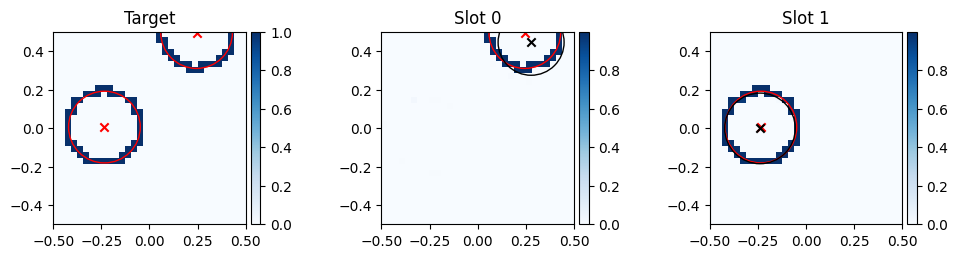

KL:  tensor(1.9216e-05)


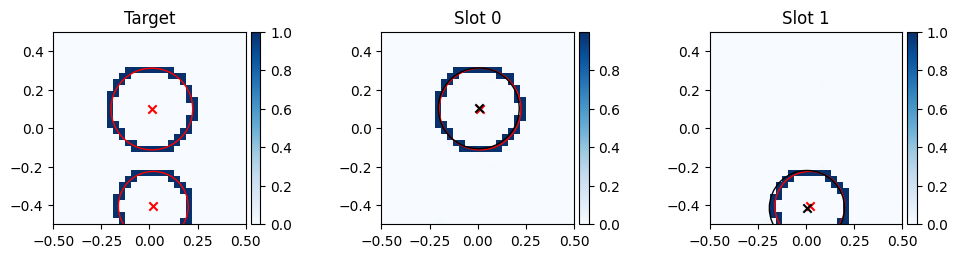

KL:  tensor(1.3300e-06)


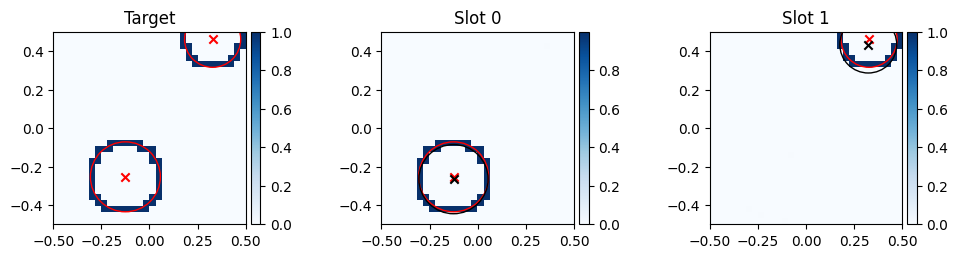

KL:  tensor(1.1152e-05)


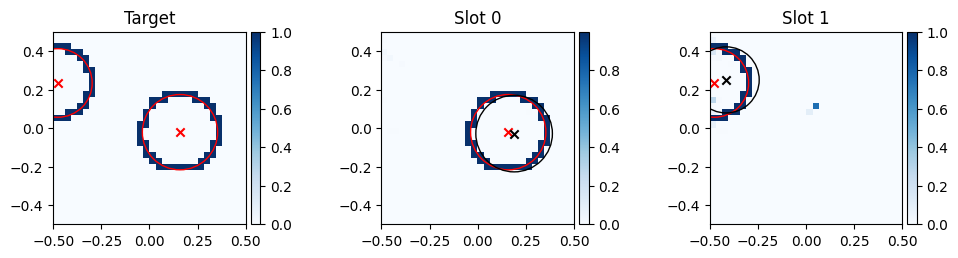

KL:  tensor(1.9835e-06)


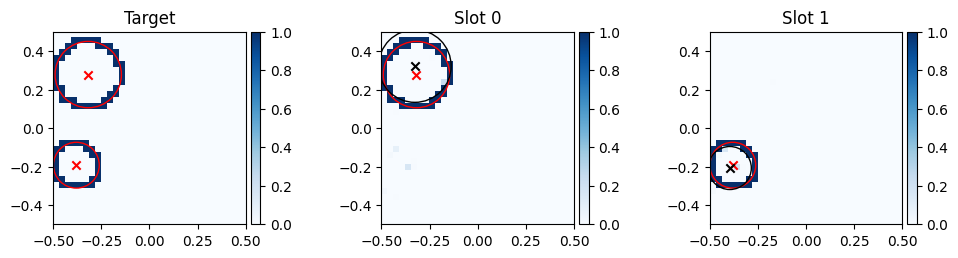

In [21]:
for count, k in enumerate(np.where(l_kl < 10e-5)[0]):
    iEvt = k
    print("KL: ", l_kl[iEvt])
    plot_chosen_slots_only(
                  mask[iEvt].sum(axis=0), 
                  slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                  Y_true_sorted[iEvt],
                  Y_pred_sorted[iEvt])
    if count>15:
        break

# Evalutation - KL-divergence and student t

We settled to use the 
- KL-divergence for the goodness of separation
- student-t fit over x,y,E resolution.

Let's implement functions!!

In [22]:
l_kl = np.nan_to_num(l_kl) # nan to zero as 0*log(0) is nan but should be zero

In [23]:
def KL_divergence(slots_sorted, rings_sorted):
    l_kl = F.kl_div(torch.log(slots_sorted),rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)
    l_kl = np.nan_to_num(l_kl)
    plt.hist(l_kl, bins=70)
    plt.yscale('log')
    plt.xlabel("KL-divergence")
    plt.ylabel("counts")
    plt.show()
    return np.mean(l_kl)

In [24]:
F.kl_div(torch.log(slots_sorted),rings_sorted,reduction='none').shape

torch.Size([1000, 2, 1024])

In [25]:
F.kl_div(torch.log(slots_sorted),rings_sorted,reduction='none').sum(axis=1).shape

torch.Size([1000, 1024])

In [26]:
F.kl_div(torch.log(slots_sorted),rings_sorted,reduction='none').sum(axis=1).sum(axis=-1).shape # sum over all pixels.

torch.Size([1000])

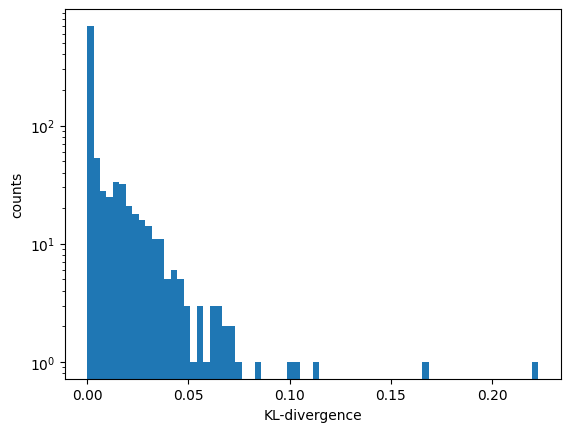

0.0070981206

In [27]:
KL_divergence(slots_sorted, rings_sorted) # average KL-divergence over the data====

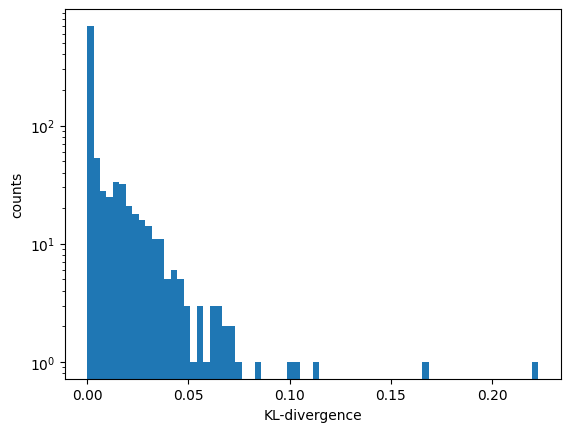

0.0070981206

In [28]:
 KL_divergence(slots_sorted, rings_sorted)

In [29]:
Y.shape

torch.Size([1000, 2, 3])

In [30]:
Y[0]

tensor([[-0.2802, -0.3461,  0.1204],
        [-0.2937, -0.3273,  0.1320]])

In [31]:
del_x1 = Y_pred_sorted[:,1,0]-Y_true_sorted[:,1,0]

In [32]:
del_x1[:10]

tensor([-0.0195, -0.0272,  0.0096,  0.0198, -0.0498, -0.0299, -0.0765, -0.0232,
        -0.0299,  0.0115])

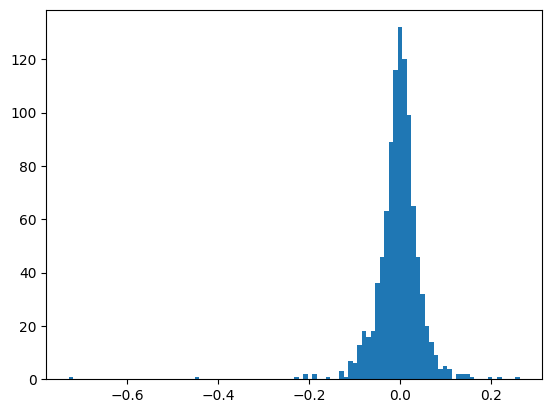

In [33]:
plt.hist(del_x1.numpy(), bins=100)
plt.show()

In [34]:
from scipy.stats import t
from scipy import stats
from scipy.optimize import curve_fit

In [35]:
plt.style.use('standard_style.mlpstyle')

In [36]:
def student_t(Y_pred_sorted, Y_true_sorted, n_rings=2, title=r"ISA, $\alpha=3$"):
    fig, axs = plt.subplots(1, 3,figsize=(12 ,3))
    #fig.suptitle(title)
    div =  (Y_pred_sorted-Y_true_sorted).reshape(bs*n_rings, 3).T
    labels = [r"$x$ resolution", r"$y$ resolution", r"$R$ resolution"]

    for i, (ax, label) in enumerate(zip(axs[0:], labels)):
        # fit with student t
        df, loc, scale = t.fit(div[i])
        label_fit= f" df={round(df, 3)},\n mean={round(loc,3)},\n scale={round(scale,3)}"
        # plot
        n_counts, containers, patches = ax.hist(div[i], bins=100, density=True) #desity=True to return a probability density!
        x_min = np.amax(np.array([containers[0], -0.25]))
        x_max = np.amin(np.array([containers[-1], 0.25]))
        x = np.linspace(x_min, x_max, 200)
        ax.plot(x, t.pdf(x, df, loc=loc, scale=scale), '--', label=' t-distribution \n'+ label_fit)
        ax.set_xlabel(label)
        ax.set_ylabel("counts")
        ax.legend()
    plt.tight_layout()
    plt.show()

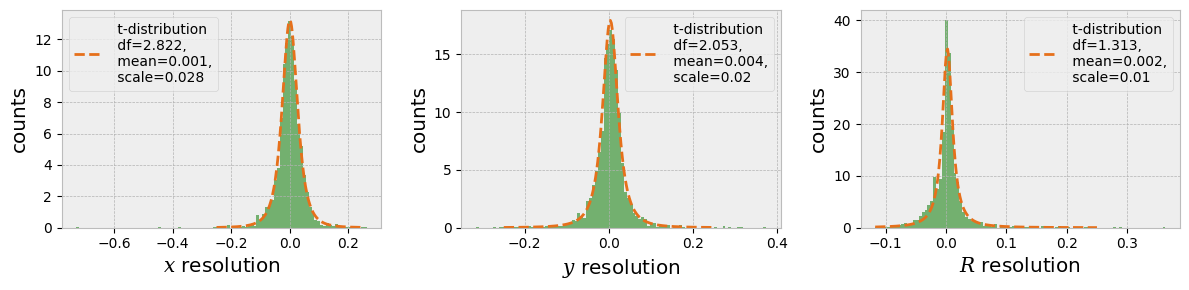

In [37]:
student_t(Y_pred_sorted, Y_true_sorted)

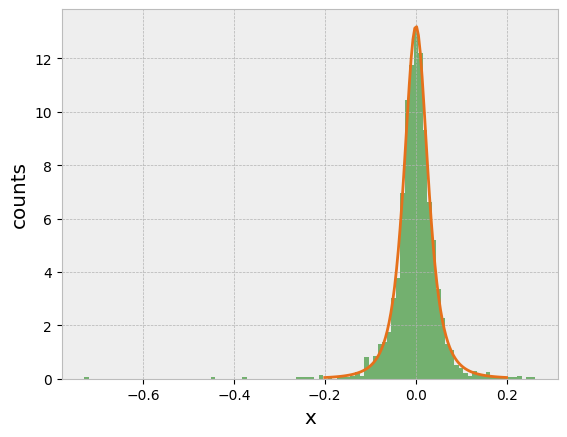

In [38]:
n_rings = 2
label="x"
div =  (Y_pred_sorted-Y_true_sorted).reshape(bs*n_rings, 3).T
i = 0
n_counts, containers, patches = plt.hist(div[i], bins=100, density=True)
plt.xlabel(label)
plt.ylabel("counts")
x_centers = 0.5*(containers[:-1]+containers[1:])

# fit with student t

df, loc, scale = t.fit(div[i])
x = np.linspace(-0.2, 0.2, 100)
dx = x[1] - x[0] # distance from 2 points
dx0 = x_centers[1] - x_centers[0] # distance of two bins
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale))

# Evaluation with script $\alpha=3$

In [39]:
import evaluation as ev

KL-divergence:  0.0070981206


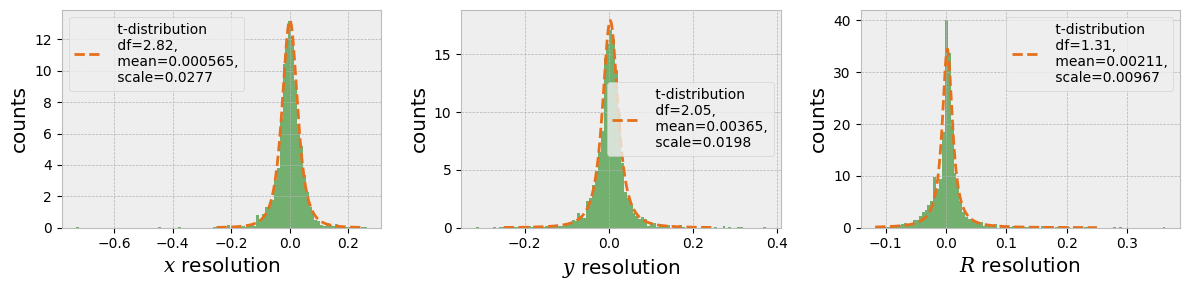

array([[2.82195009e+00, 5.64917450e-04, 2.76847306e-02],
       [2.05330198e+00, 3.64995818e-03, 1.97606748e-02],
       [1.31268914e+00, 2.11413706e-03, 9.66938076e-03]])

In [40]:
print("KL-divergence: ", ev.KL_divergence(slots_sorted, rings_sorted))
ev.student_t(Y_pred_sorted, Y_true_sorted)